In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dill

from python.mappings import FOOTBALL_LEAGUES_MAPPING, TEAMS_RANKING_MAPPING, EUROPEAN_TOURNAMENTS_MAPPING, PLAYERS_OUTSIDE_TOP5

from scipy.stats import norm, skew
from scipy.stats import probplot
from scipy.stats import f_oneway, shapiro, levene, kruskal

from scipy.special import boxcox1p
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate, KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint as sp_randint

from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR, NuSVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

from sklearn.metrics import root_mean_squared_error, root_mean_squared_log_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import make_scorer

%matplotlib inline

In [92]:
# Constant variables
TABLE_SIZE = 1546
TRAIN_RATIO = 0.8

In [93]:
# Joins train and test datasets together to simplify the process
def concat_df(df1, df2):
    return pd.concat([df1, df2], ignore_index=True)

# Divides the overall dataset into train and test 
def divide_df(df):
    train_size = int(TABLE_SIZE*TRAIN_RATIO)
    
    return df.loc[:train_size - 1], df.loc[train_size:] 

In [94]:
train_data = pd.read_csv('data/train_stats.csv')
test_data = pd.read_csv('data/test_stats.csv')
all_data = concat_df(train_data, test_data)
df_train, df_test = divide_df(all_data)

In [95]:
clean_sheets = pd.read_csv('data/footballers_clean_sheets.csv')
popularity = pd.read_csv('data/footballers_popularity.csv')

In [96]:
all_data = all_data.merge(right=clean_sheets, on=['Name'], how='left')
all_data = all_data.merge(right=popularity, on=['Name'], how='left')

In [97]:
all_data['Clean Sheets %'].fillna(value=0, inplace=True)
all_data['Popularity'].fillna(value=1, inplace=True)

**1. PREPARATION STEP: Cleaning the data**

In [98]:
all_data.drop(['Player_URL', 'Team_URL'], axis=1, inplace=True)

In [99]:
# Cleans the columns containing commas 
def clean_comma(column):
    column = column.strip()
    column = column[:column.find(',')] + '' + column[column.find(',') + 1:]
    return column

# Cleans the columns containing '\t' symbol
def clean_tab(column):
    return column.strip().replace('\t', '')

In [100]:
comma_columns = ['Team', 'Position']
tab_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
               'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Blocks', 'OwnG', 'KeyP',
               'Drb_y', 'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in comma_columns:
    all_data[column] = all_data[column].apply(clean_comma)
    
for column in tab_columns:
    all_data[column] = all_data[column].apply(clean_tab)

In [101]:
# Some columns with integer values contain symbol '-' instead of 0. The function fixes it
def remove_dashes(column):
    if column == '-':
        return 0
    return column

In [102]:
dash_columns = ['Goals', 'Assists', 'Yel', 'Red', 'SpG', 'AerialsWon', 'MotM', 'Tackles',
                'Inter', 'Fouls', 'Offsides', 'Clear', 'Drb_x', 'Drb_y', 'Blocks', 'OwnG', 'KeyP',
                'Fouled', 'Off', 'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']

for column in dash_columns:
    all_data[column] = all_data[column].apply(remove_dashes)

In [103]:
# Now we have 'Value' variable containing market values in thousands or millions, but we want to get just an integer
def value_scaling(value):
    value = value.strip()
    
    if value.endswith('k'):
        return int(float(value[value.find('€')+1:value.find('k')]) * 10**3)
    elif value.endswith('m'):
        return int(float(value[value.find('€')+1:value.find('m')]) * 10**6)

In [104]:
all_data['Value'] = all_data['Value'].apply(value_scaling)

In [105]:
# We can divide 'Apps' variable because the number of appearances in starting squad is demonstrated in parentheses 
def appearances_division(apps):
    return apps[:apps.find('(')], apps[apps.find('(')+1:apps.find(')')]

In [106]:
all_data['Overall_Apps'], all_data['Start_Apps'] = zip(*all_data['Apps'].apply(appearances_division))

In [107]:
all_data.drop(['Apps'], axis=1, inplace=True)

In [108]:
# It would be better if we replace 'Forward', 'Midfielder' with their short forms (FW, M)

#all_data['Position'].value_counts()

def position_mapping(position):
    position = position.strip()
    
    if position == 'Forward': 
        return 'FW'
    elif position == 'Midfielder': 
        return 'M(C)'
    return position

all_data['Position'] = all_data['Position'].apply(position_mapping)

In [109]:
# We can divide 'Position' column into two positions (if some player has only one position, he`ll get NaN value for the second one).#
def position_division(position):
    
    # only two main positions, that`s enough
    if position.count(',') >= 2:
        while position.count(',') != 1:
            position = position[:position.rfind(',')]
          
    if position.find(',') != -1:
        return pd.Series([position[:position.find(',')].strip(), position[position.find(',')+1:]]).values
    return pd.Series([position.strip(), np.nan]).values

# Center (C), Right (R) or Left (L)? This information is contained in parentheses
def position_side(position):
    
    # np.nan has 'float' type
    if type(position) != float:
        if position.find('(') != -1:
            sides = tuple(position[position.find('(')+1:position.find(')')])
            position = position[:position.find('(')].strip(),
            
            return position + sides + tuple([np.nan] * (3 - len(sides)))
        else:
            position = position.strip(),

            return position + tuple([np.nan] * 3)
    else:
        return tuple([np.nan] * 4)

In [110]:
all_data['Position_1'], all_data['Position_2'] = zip(*all_data['Position'].apply(position_division))

In [111]:
all_data['Position_1'], all_data['Side_11'], all_data['Side_12'], all_data['Side_13'] = zip(*all_data['Position_1'].apply(position_side))
all_data['Position_2'], all_data['Side_21'], all_data['Side_22'], all_data['Side_23'] = zip(*all_data['Position_2'].apply(position_side))

In [112]:
all_data.drop(['Position'], axis=1, inplace=True)

In [113]:
# Time to change column types
float_type = ['SpG', 'AerialsWon', 'Tackles', 'Inter', 'Fouls', 'Offsides',
              'Clear', 'Drb_x', 'Blocks', 'KeyP', 'Drb_y', 'Fouled', 'Off',
              'Disp', 'UnsTch', 'Crosses', 'LongB', 'ThrB']
int_type = ['Goals', 'Assists', 'Yel', 'Red', 'MotM', 'OwnG', 'Overall_Apps', 'Start_Apps']

all_data[float_type] = all_data[float_type].astype('float')
all_data[int_type] = all_data[int_type].astype('int64')

In [114]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

# Insert 'Position_2' variable before the variable 'Side_21'
pos2_column = all_data.pop('Position_2')
index = all_data.columns.get_loc('Side_21')
all_data.insert(index, 'Position_2', pos2_column)

In [115]:
all_data = all_data[all_data['Value'] < 100000000]
all_data = all_data[(all_data['Age'] < 32) | (all_data['Popularity'] < 3)]

In [116]:
all_data[all_data['Name'] == 'Jacob Murphy']

,Name,Team,Age,Mins,Goals,Assists,Yel,Red,SpG,PS,...,Start_Apps,Position_1,Side_11,Side_12,Side_13,Position_2,Side_21,Side_22,Side_23,Value
1275,Jacob Murphy,Newcastle,29,1194,3,7,1,0,1.4,73.6,...,7,D,R,NaN,NaN,M,L,R,NaN,15000000


**2. EXPLORATORY DATA ANALYSIS AND FEATURE ENGINEERING**

**GLOSSARY. DESCRIPTION OF THE VARIABLES**

- SpG - Shots per game
- PS(%) - Percentage of successful passes
- AerialsWon, Aerial - Header in a direct contest with an opponent
- MotM - Man of the Match
- Tackle - Dispossessing an opponent, whether the tackling player comes away with the ball or not
- Interception (Inter) - Preventing an opponent's pass from reaching their teammates
- Fouls - How often a player commits a foul
  Fouled - How often a player gets fouled
- Offsides - It`s referred to "offside won" - the last man to step up to catch an opponent in an offside position
  Off - How often a player gets in offside position
- Clearance (Clear) - Action by a defending player that temporarily removes the attacking threat on their goal/that effectively alleviate pressure on their goal
- Drb_x - How often a player gets dribbled (being dribbled past by an opponent without winning a tackle)
  Drb_y - Frequency of successful dribbles
- Blocks - The number of blocked shots per game
- OwnG - Own goal
- KeyP - Key passes (the final pass leading to a shot at goal from a teammate)
- Dispossessed (Disp) - How often a player gets tackled by an opponent without attempting to dribble past them
- UnsTch - ???
- Average Passes (AvgP) - Average number of passes attempted (short passes, long balls, through balls, crosses)
- Cross - An attempted/accurate pass from a wide position to a central attacking area
- Long Ball (LongB) - An attempted/accurate pass of 25 yards or more
- Through Ball (ThrB) - An attempted/accurate pass between opposition players in their defensive line to find an onrushing teammate (running through on goal)
- Apps - appearances on the football field

In [28]:
df_train, df_test = divide_df(all_data)

Let`s start with categorical variables.

We see that there are a lot of missing values for 'Side_2X' and 'Side_13' variables (>80%). It describes where a player is located on a football pinch (left, right or center). But it can be useful to create a variable that shows how much place some player "occupies", on how many sides he is able to play. If it isn`t shown (all three variables are NaN values), then we will set 1.

In [117]:
def position_sides(s1, s2, s3):
    sides_list = [s1, s2, s3]
    
    while np.nan in sides_list:
        sides_list.remove(np.nan)
    
    if len(sides_list) == 0:
        return 1
    return len(sides_list)

In [118]:
all_data['Position_1_Sides'] = all_data.apply(lambda x: position_sides(x['Side_11'], x['Side_12'], x['Side_13']), axis=1)
all_data['Position_2_Sides'] = all_data.apply(lambda x: position_sides(x['Side_21'], x['Side_22'], x['Side_23']), axis=1)

Other variables have no missing values so we can continue in our research

'Team' variable can be very useful: we can extract a league in which a football player competes, and it is somehow influences his market value. For instance, we expect that in Premier League players cost more because of higher level of this championship and some other aspects. For this task we will use our mapping.

Also, we can divide our teams into three groups (A, B, C) based on their level ranking. Perhaps, players from "big teams" are more expensive 

In [119]:
all_data['League'] = all_data['Team'].map(FOOTBALL_LEAGUES_MAPPING)
all_data['Team_rank'] = all_data['Team'].map(TEAMS_RANKING_MAPPING)
all_data['European tournament'] = all_data['Team'].map(EUROPEAN_TOURNAMENTS_MAPPING)
all_data['Out of top5'] = all_data['Name'].isin(PLAYERS_OUTSIDE_TOP5)

Let`s check our presumptions by creating some plots!

In [120]:
order_rank = ['A-tier', 'B-tier', 'C-tier']

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='League',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Team_rank',
            y='Value',
            order=reversed(order_rank),
            ax=ax[1])

ax[0].set_title('The distribution of samples across the leagues')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of samples across the team rankings')
ax[1].set_xlabel('Rank')
ax[1].set_ylabel('')

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='League')

ax.set_title('The distribution of market values across the leagues')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Team_rank',
            hue_order=order_rank)

ax.set_title('The distribution of market values based on the team rank')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 14))

sns.swarmplot(all_data,
              x='League',
              y='Value',
              size=4,
              hue='Team_rank',
              hue_order=order_rank,
              ax=ax)

ax.set_title('The distribution of samples across the leagues and team rankings', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)', fontsize=18)
ax.xaxis.label.set_size(18)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(bbox_to_anchor=(1, 1), loc=2, fontsize=15)

plt.show()

On the first graph we can see that the distributions are almost the same across the leagues, but the Premier league has a little bit different one with higher market values than for other leagues.

From the second one we can notice that the distributions for A-ranked and B-ranked clubs are more heavy-tailed than for C-ranked teams, and in general, the majority of players in "small clubs" are located on the left part of the graph.

In [ ]:
# Creates a table with different descriptive statistics for different groups of a categorical variable 
def descriptive_table(table, variable):
    indices=table.groupby(variable)['Value'].mean().index
    counts = table.groupby(variable)['Value'].count().values
    means = table.groupby(variable)['Value'].mean().values
    stds = table.groupby(variable)['Value'].std().values
    medians = table.groupby(variable)['Value'].median().values
    quantile_ninty = table.groupby(variable)['Value'].quantile(q=0.9).values
    
    table =  pd.DataFrame({'Sample size': counts,
                           'Mean': means,
                           'St. deviation': stds,
                           'Median': medians,
                           '90% quantile': quantile_ninty
                           }, index=indices)
    return table    

In [ ]:
for item in ['League', 'Team_rank']:
    print(f"Variable: {item}")
    display(descriptive_table(all_data, item))

**Idea**: We can create a variable that indicates whether some footballer plays in Premier League instead of 'League' column

In [121]:
all_data['From EPL'] = all_data['League'] == 'Premier League'

In [122]:
all_data['Champion'] = all_data['Team'].isin(['Inter', 'Real Madrid', 'Leverkusen', 'Man City', 'PSG'])

Now we will work with positions. It can be very useful to divide player`s positions into four groups (attack, midfield, defence and goalkeeper) because we can expect that the players in attack line cost more than goalkeepers. We will only operate with the main position and create 'Position' column.

In [123]:
position_mapping = {'FW': 'Attack',
                    'AM': 'Midfield',
                    'M': 'Midfield',
                    'DMC': 'Midfield',
                    'D': 'Defence',
                    'GK': 'Goalkeeper'}

all_data['Position'] = all_data['Position_1'].map(position_mapping)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

position_rank = ['Goalkeeper', 'Defence', 'Midfield', 'Attack']

sns.boxplot(all_data,
            x='Position',
            y='Value',
            order=position_rank,
            ax=ax[0])

sns.stripplot(all_data,
              x='Position',
              y='Value',
              order=position_rank,
              ax=ax[1])

fig.suptitle('The distribution of samples depending on positions', fontsize=20)
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_ylabel('')

plt.show()

In [773]:
display(descriptive_table(all_data, 'Position'))

KeyError: 'Position'

In [774]:
# Significance test for some categorical variable
def significance_test(variable, transformation=False, test_type=None):
    groups = []

    for group in all_data[variable].unique():
        sample = all_data.query(variable + '== @group')['Value'].values
        
        if transformation == 'log': 
            sample = np.log(sample + 1)
        elif transformation == 'sqrt': 
            sample = np.sqrt(np.abs(sample))
            
        print(f'Shapiro-Wilk test: {shapiro(sample)}')
        groups.append(sample)

    print(f'Levene: {levene(*groups)}')
    
    if test_type == 'anova':
        print(f'ANOVA test: {f_oneway(*groups)}')
    elif test_type == 'kruskal':
        for g in groups:
            np.sort(g)
            
        print(f'Kruskal-Wallis test: {kruskal(*groups)}')

In [775]:
significance_test('Position')

KeyError: 'Position'

The samples aren`t distributed normally and their variances differ significantly, but we can use transformations

In [776]:
for tr in ['log', 'sqrt']:
    significance_test('Position', transformation=tr)
    print()
    print('=' * 25)
    print()

KeyError: 'Position'

The samples` distribution is still abnormal, but their variances are homogenous, so we can try to use Kruskal-Wallis test (we cannot use ANOVA test)

In [777]:
print('Without transformation: ')
significance_test('Position', transformation=False, test_type='kruskal')

Without transformation: 


KeyError: 'Position'

In [778]:
print('With log transformation: ')
significance_test('Position', transformation='log', test_type='kruskal')

With log transformation: 


KeyError: 'Position'

Since Kruskal-Wallis test shows significant result, we can leave this variable

Let`s check 'Side_11' variable because it is footballer's main side (location where he usually plays)

In [779]:
fig, ax = plt.subplots(figsize=(10, 6))

side_rank = ['L', 'C', 'R']

sns.boxplot(all_data,
            x='Side_11',
            y='Value',
            order=side_rank,
            ax=ax)

fig.suptitle('The distribution of samples based on the side on the football pinch', fontsize=20)
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')
ax.set_xlabel('Side')

plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x0000018277001BD0> (for post_execute):



KeyboardInterrupt



In [ ]:
descriptive_table(all_data, 'Side_11')

In [124]:
all_data['Side_11'].fillna(all_data['Side_11'].mode().values[0], inplace=True)
#all_data['Side_11'] = all_data.groupby('Position')['Side_11'].transform(lambda x: x.fillna(x.mode()))

In [125]:
all_data.rename(columns={'Side_11': 'Main side'}, inplace=True)

This variable is not so useful as the previous ones. There are too little data for Left and Right sides, and we can expect that 'Side_12', 'Side_13', etc. are even less informative, so in the future we can drop them, leaving only 'Main_side' (it is the same as 'Side_11') variable.

Now we will work with 'Position_1_Sides' and 'Position_2_Sides' and create some interesting (at least we hope) plots

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.kdeplot(all_data,
            x='Value',
            hue='Position_1_Sides',
            palette=['blue', 'green', 'orange'])

ax.set_title('The distribution of market values depending on the number of positions a footballer occupies')
ax.set_xlabel('Market value (in millions)')
ax.set_xticks(ticks=[0, 0.5e8, 1e8, 1.5e8, 2e8], labels=['0', '50m', '100m', '150m', '200m'])

plt.show()

Now let`s work with numerical variables  

In [ ]:
all_data.describe()

In [ ]:
df_train, df_test = divide_df(all_data)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Age',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Age',
            kde=True,
            bins=18,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by age')
ax.set_xlabel('Age')
ax.legend()

plt.show()

In [780]:
#all_data['Age'] = pd.cut(all_data['Age'], bins=4)

In [126]:
all_data['Very old'] = all_data['Age'] >= 32

In [782]:
df_train, df_test = divide_df(all_data)

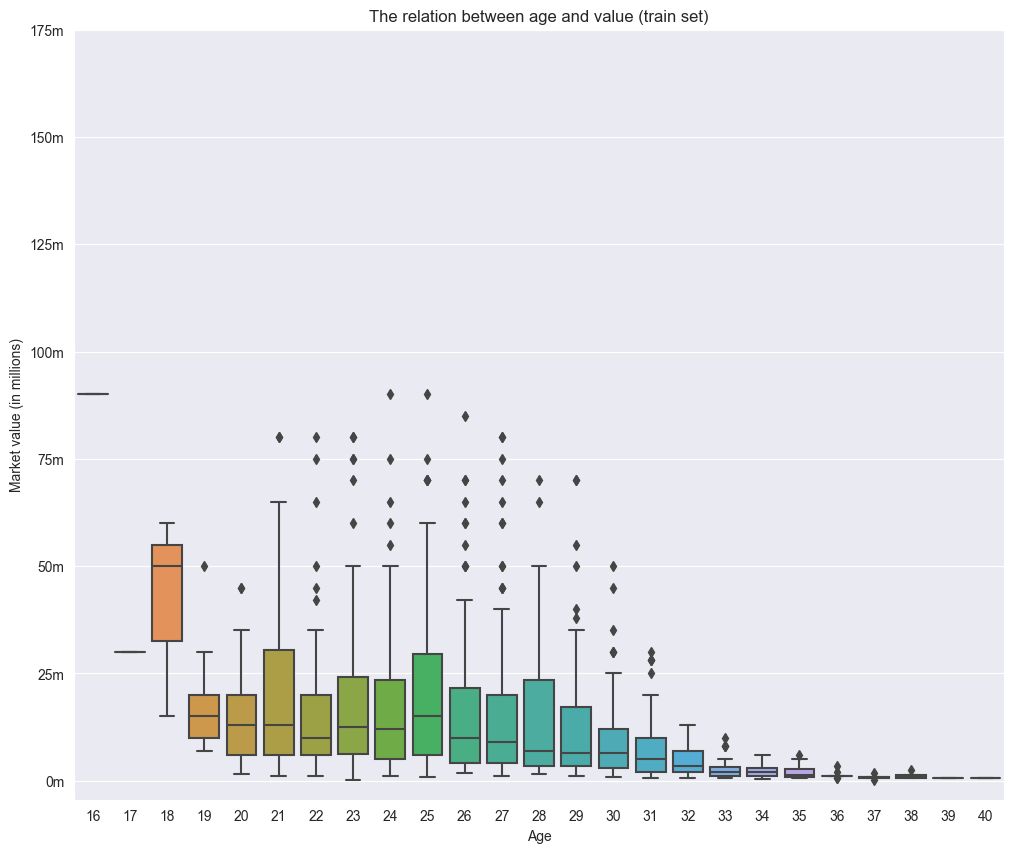

In [783]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Age',
            y='Value',
            ax=ax)

ax.set_title('The relation between age and value (train set)')
ax.set_xlabel('Age')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [784]:
descriptive_table(df_train, 'Age')

,Sample size,Mean,St. deviation,Median,90% quantile
Age,,,,,
16,1,9.000000e+07,NaN,90000000.0,90000000.0
17,1,3.000000e+07,NaN,30000000.0,30000000.0
18,3,4.166667e+07,2.362908e+07,50000000.0,58000000.0
19,15,1.773333e+07,1.132927e+07,15000000.0,29200000.0
20,33,1.562121e+07,1.177791e+07,13000000.0,30000000.0
21,56,2.055357e+07,1.959492e+07,13000000.0,47500000.0
22,77,1.599481e+07,1.596661e+07,10000000.0,35000000.0
23,98,1.922296e+07,1.884589e+07,12500000.0,48600000.0
24,98,1.745000e+07,1.702033e+07,12000000.0,40000000.0


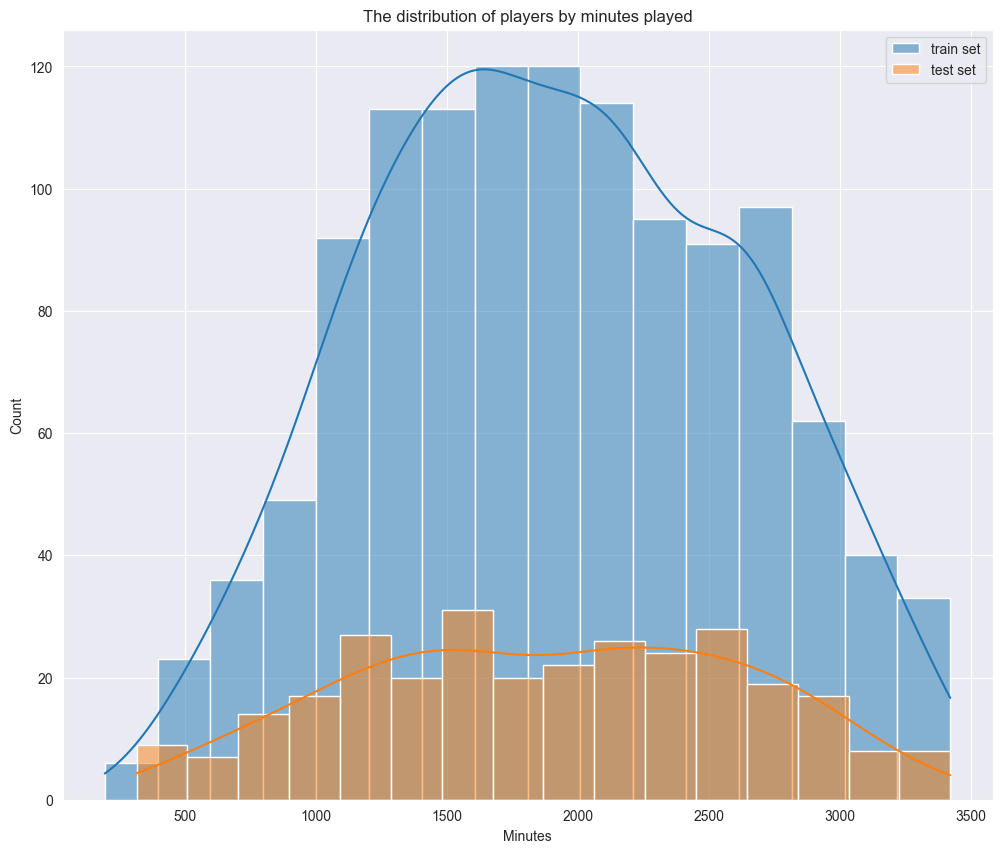

In [785]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.histplot(df_train,
            x='Mins',
            kde=True,
            ax=ax,
            label='train set')

sns.histplot(df_test,
            x='Mins',
            kde=True,
            bins=16,
            ax=ax,
            label='test set')

ax.set_title('The distribution of players by minutes played')
ax.set_xlabel('Minutes')
ax.legend()

plt.show()

ValueError: Could not interpret value `Position` for parameter `hue`

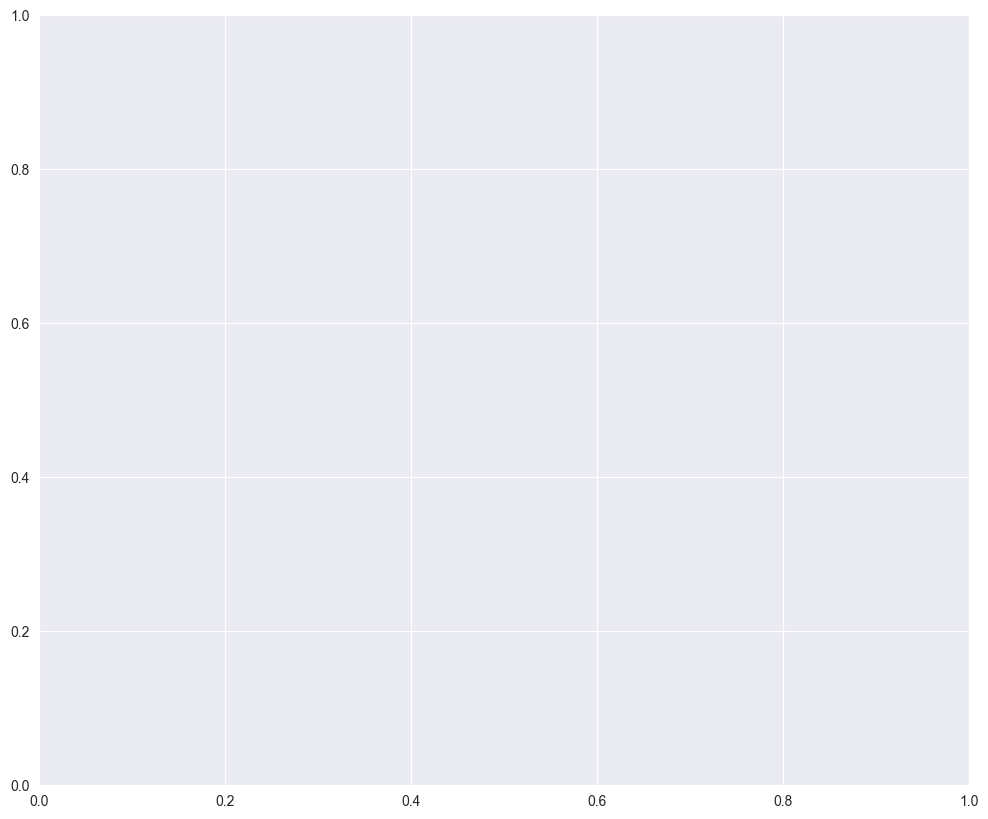

In [786]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.scatterplot(df_train,
            x='Mins',
            y='Value',
            hue='Position',
            hue_order=position_rank,
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [ ]:
sns.jointplot(df_train,
              x='Mins',
              y='Value',
              kind="hex", 
              height=8,
              color="#FFF668")

plt.show()

In [ ]:
#all_data['Minutes for MotM'] = all_data['Mins'] / all_data['MotM']
#all_data['Minutes for Goal'] = all_data['Mins'] / all_data['Goals']
#all_data['Minutes for Assist'] = all_data['Mins'] / all_data['Assists']
#all_data['Minutes for KeyP'] = all_data['Mins'] / all_data['KeyP']

In [81]:
#all_data['Mins'] = pd.qcut(all_data['Mins'], q=4)
df_train, df_test = divide_df(all_data)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

sns.boxplot(df_train,
            x='Mins',
            y='Value',
            ax=ax)

ax.set_title('The distribution of market values depending on how many minutes a footballer played')
ax.set_xlabel('Mins')
ax.set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax.set_ylabel('Market value (in millions)')

plt.show()

In [787]:
descriptive_table(df_train, 'Mins')

,Sample size,Mean,St. deviation,Median,90% quantile
Mins,,,,,
195,1,6.000000e+05,NaN,600000.0,600000.0
209,1,3.000000e+06,NaN,3000000.0,3000000.0
334,1,8.000000e+06,NaN,8000000.0,8000000.0
368,1,2.000000e+06,NaN,2000000.0,2000000.0
392,1,8.000000e+06,NaN,8000000.0,8000000.0
...,...,...,...,...,...
3406,1,3.000000e+06,NaN,3000000.0,3000000.0
3407,1,3.500000e+06,NaN,3500000.0,3500000.0
3414,1,5.000000e+06,NaN,5000000.0,5000000.0


In [127]:
all_data['Goals'] = pd.cut(all_data['Goals'], bins=4)
all_data['Assists'] = pd.cut(all_data['Assists'], bins=4)

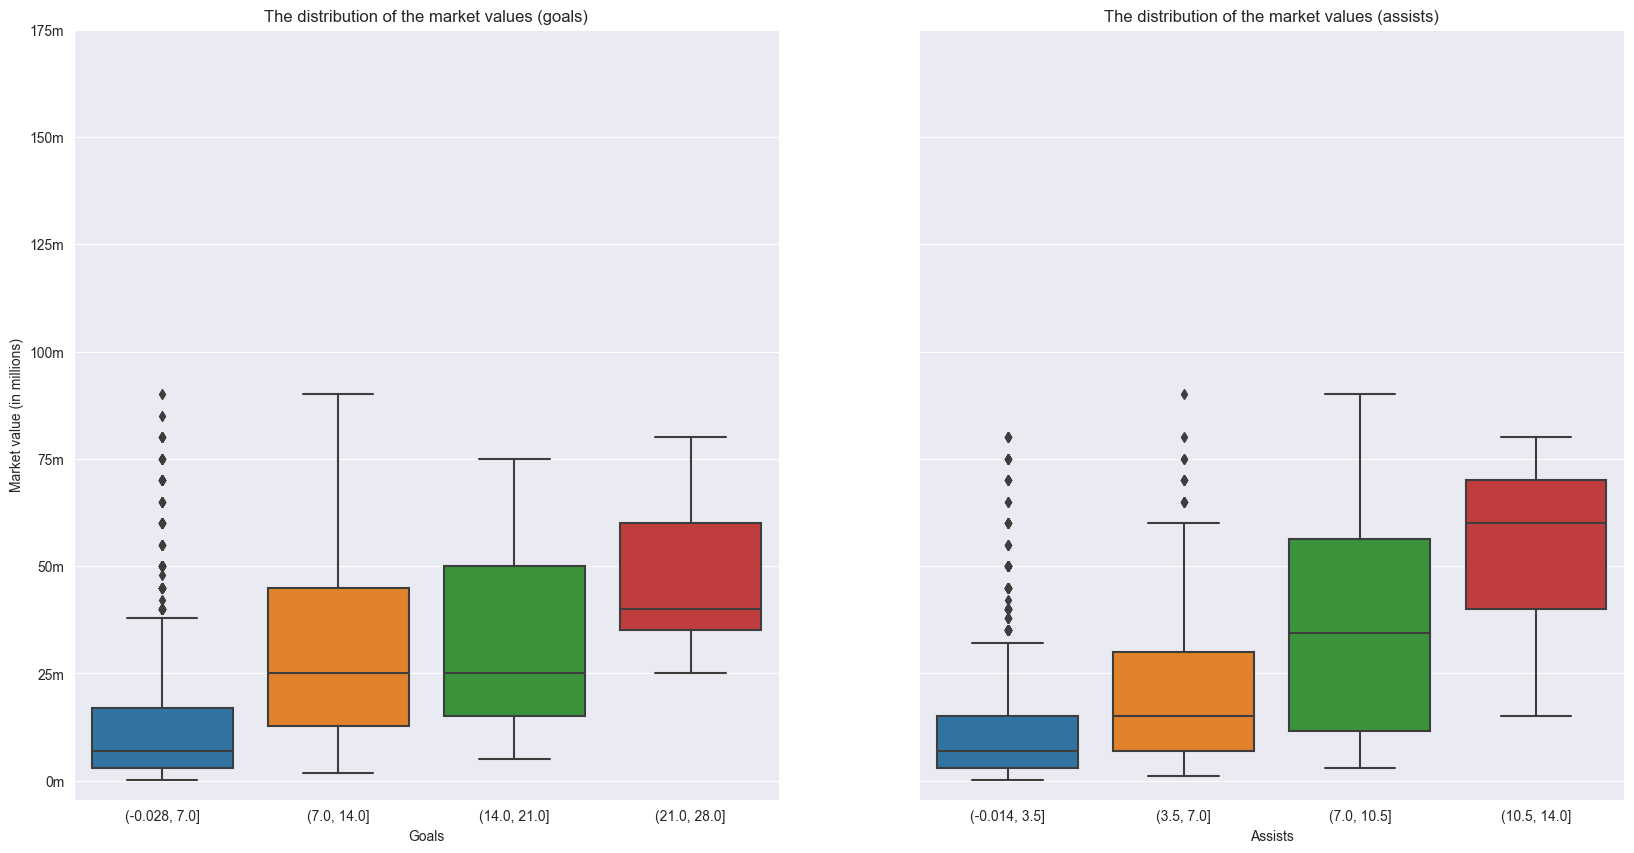

In [83]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

sns.boxplot(all_data,
            x='Goals',
            y='Value',
            ax=ax[0])

sns.boxplot(all_data,
            x='Assists',
            y='Value',
            ax=ax[1])

ax[0].set_title('The distribution of the market values (goals)')
ax[0].set_yticks(ticks=[0, 0.25e8, 0.5e8, 0.75e8, 1e8, 1.25e8, 1.5e8, 1.75e8], 
                 labels=['0m', '25m', '50m', '75m', '100m', '125m', '150m', '175m'])
ax[0].set_ylabel('Market value (in millions)')

ax[1].set_title('The distribution of the market values (assists)')
ax[1].set_ylabel('')

plt.show()

In [789]:
for item in ['Goals', 'Assists']:
    print(f'Variable: {item}')
    display(descriptive_table(all_data, item))

Variable: Goals


,Sample size,Mean,St. deviation,Median,90% quantile
Goals,,,,,
"(-0.028, 7.0]",1371,1.256003e+07,1.444838e+07,7000000.0,30000000.0
"(7.0, 14.0]",108,3.110000e+07,2.163321e+07,25000000.0,65000000.0
"(14.0, 21.0]",17,3.070588e+07,2.287948e+07,25000000.0,65000000.0
"(21.0, 28.0]",5,4.800000e+07,2.196588e+07,40000000.0,72000000.0


Variable: Assists


KeyError: 'Assists'

Let`s drop redundant features or the features with missing values

In [128]:
all_data.drop(['Side_12', 'Side_13', 'Side_21', 'Side_22', 'League', 'Team',
               'Side_23', 'Position_1', 'Position_2', 'Position_2_Sides'], axis=1, inplace=True)

all_data, all_names = all_data.drop('Name', axis=1), all_data['Name']

train_names, test_names = divide_df(all_names) 

In [791]:
all_data.sample(10)

,Team_rank,Age,Popularity,Goals,Rating,From EPL,Mins,AvgP,PS,LongB,Value,Very old
540,A-tier,30,3.0,"(-0.028, 7.0]",6.63,True,1549,50.8,94.1,0.7,30000000,False
1114,B-tier,30,1.0,"(-0.028, 7.0]",6.74,False,2700,30.5,80.1,6.6,14000000,False
846,C-tier,30,1.0,"(-0.028, 7.0]",6.24,False,1096,16.3,82.9,0.3,1800000,False
379,B-tier,25,1.0,"(-0.028, 7.0]",6.58,False,1219,26.0,76.5,0.6,5000000,False
535,B-tier,30,1.0,"(7.0, 14.0]",7.00,False,2309,22.9,79.7,0.3,7000000,False
362,C-tier,31,1.0,"(-0.028, 7.0]",6.71,False,2122,52.3,86.5,2.8,4500000,False
1057,C-tier,33,1.0,"(-0.028, 7.0]",6.66,False,2880,27.5,75.5,4.7,3500000,True
1442,B-tier,27,1.0,"(-0.028, 7.0]",6.65,False,1988,44.5,85.5,2.5,9000000,False
471,C-tier,25,1.0,"(-0.028, 7.0]",6.66,True,2895,52.5,79.7,3.3,7000000,False
1203,B-tier,28,2.0,"(21.0, 28.0]",7.73,False,2214,27.5,81.4,0.4,40000000,False


In [792]:
def pairplot_creator(table, index_start=0, index_end=40):
    new_table = table.iloc[:, index_start:index_end]
    new_table['Value'] = table['Value']
    
    sns.pairplot(new_table, height=2)
    plt.show()

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


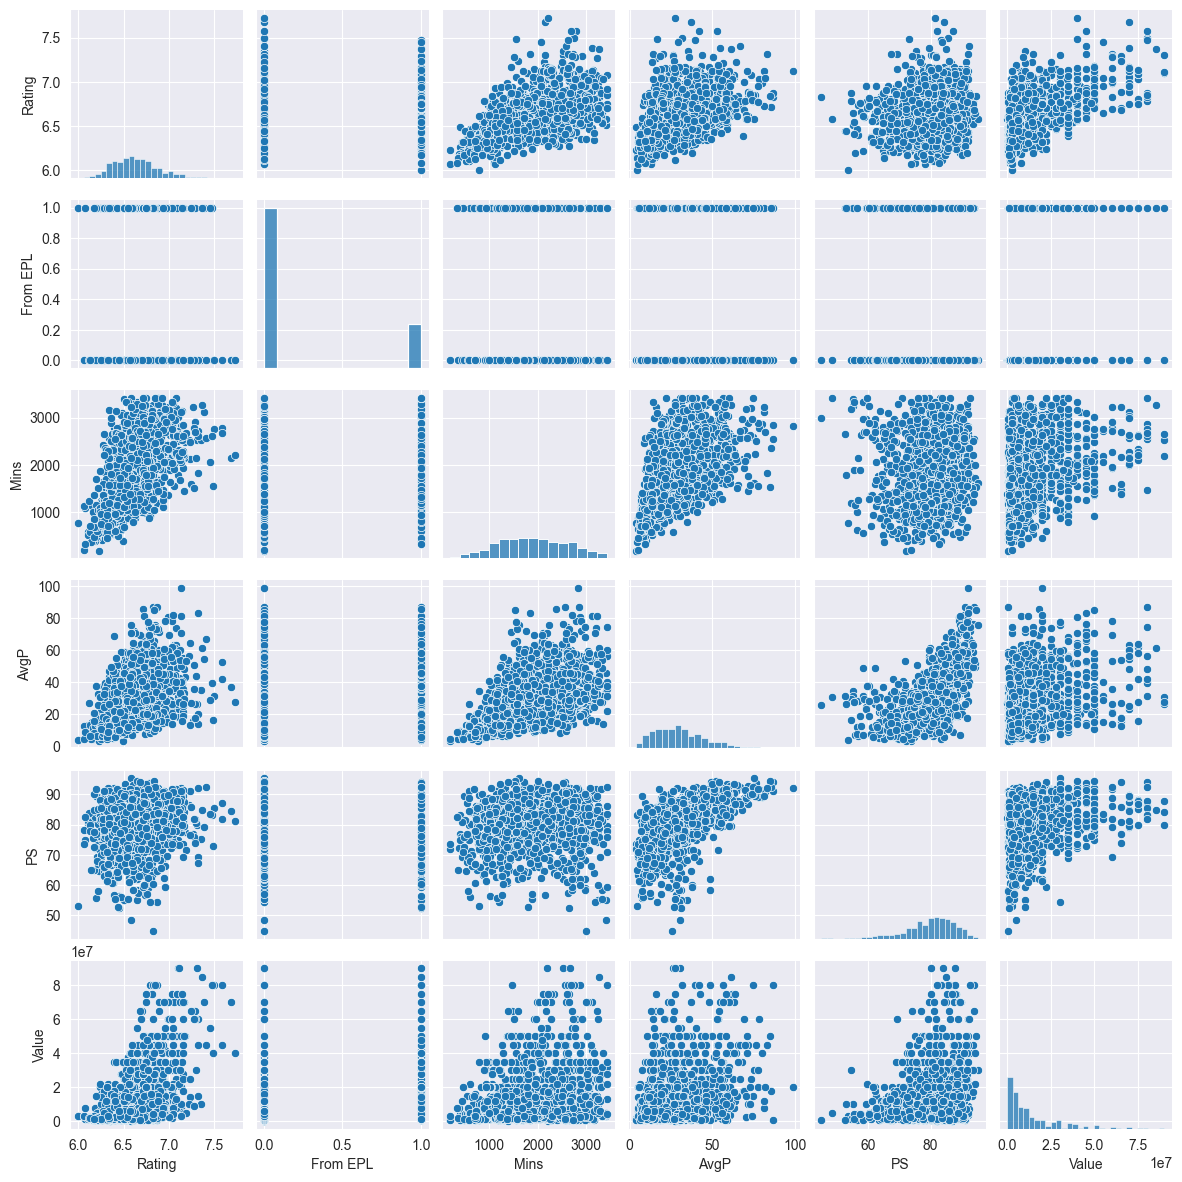

In [793]:
pairplot_creator(df_train, index_start=4, index_end=9)

In [130]:
# Insert 'Value' variable at the end of the dataset
value_column = all_data.pop('Value')
all_data['Value'] = value_column

In [129]:
df_train, df_test = divide_df(all_data)

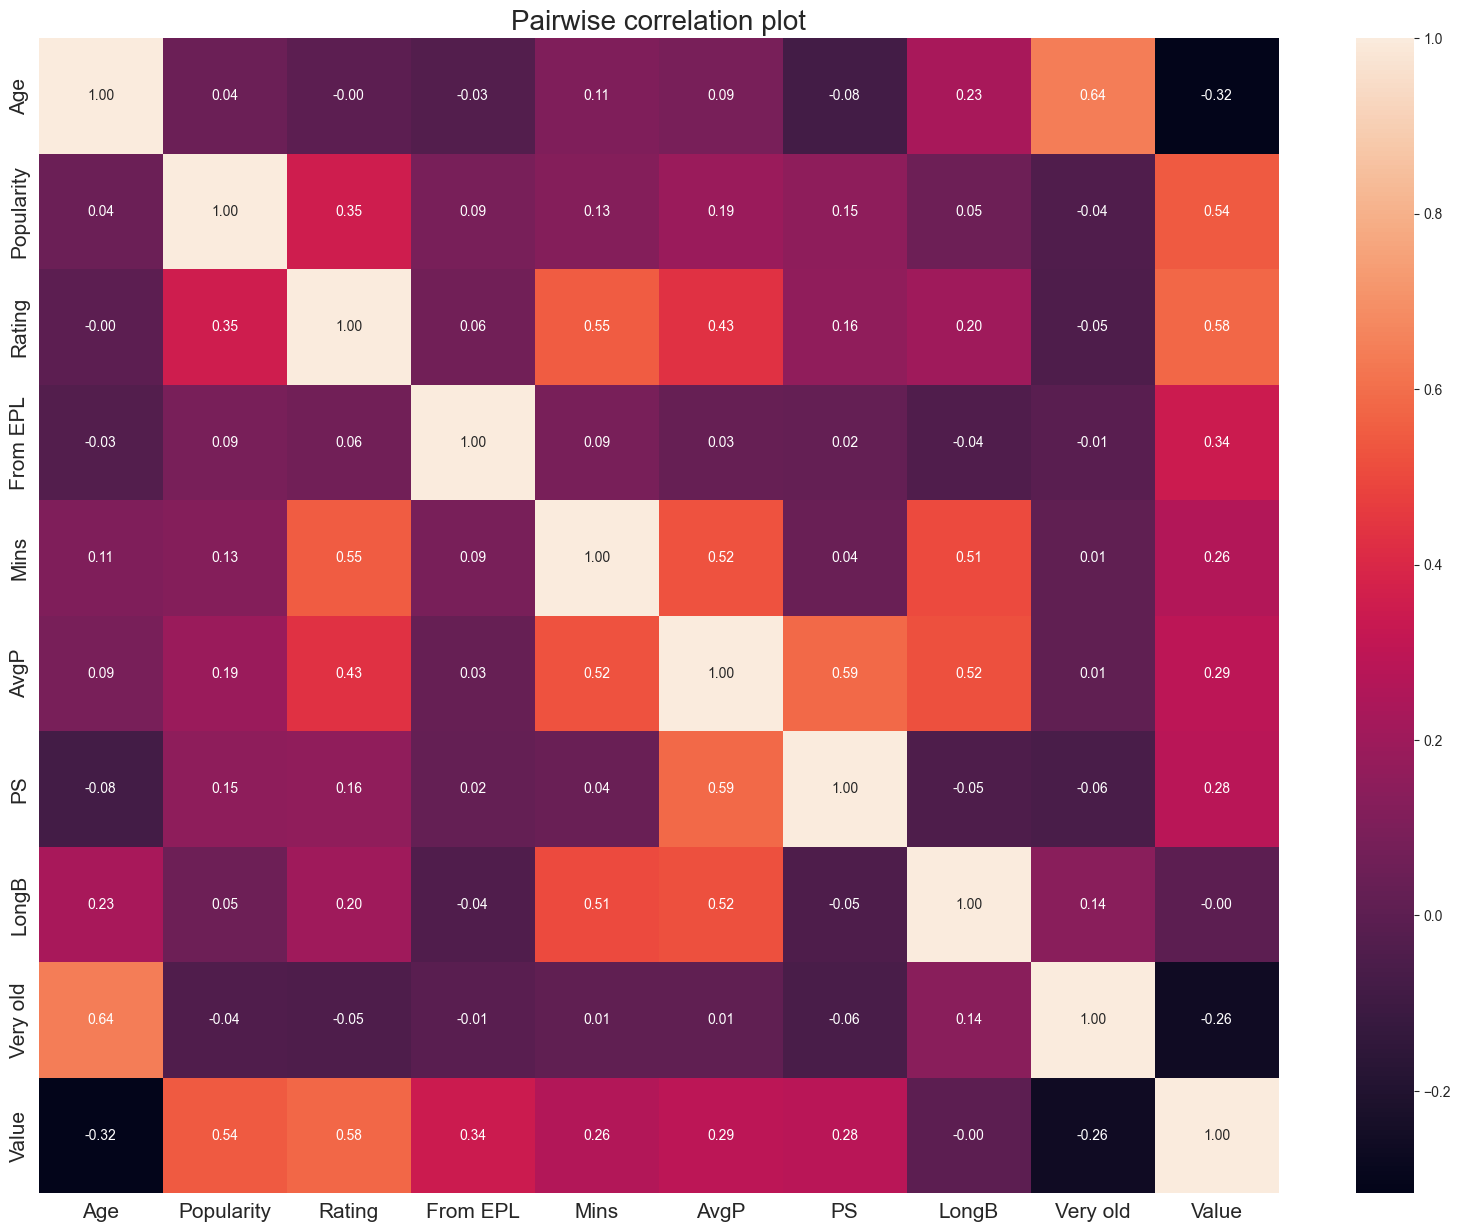

In [796]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()f

Let`s check the variance of some variables and use filter methods of feature selection

In [131]:
low_variance_correlation = []

for item in all_data.columns:
    if (all_data[item].dtype == 'int64' or all_data[item].dtype == 'float') and not item.startswith('Minutes'):
        print(f'Variable: {item}')
        variance = all_data[item].values.var()
        correlation = np.corrcoef(all_data[item].values, all_data['Value'].values)[0][1]
        print(f'Its variance: {variance}')
        print(f'Its correlation with the target variable: {correlation}')
        print('=' * 25)
        
        if variance < 0.2 and correlation < 0.1:
            low_variance_correlation.append(item)

Variable: Age
Its variance: 16.22992888152291
Its correlation with the target variable: -0.32480813271727754
Variable: Mins
Its variance: 499480.52425897727
Its correlation with the target variable: 0.24684454725888857
Variable: Yel
Its variance: 7.229348766378711
Its correlation with the target variable: 0.09198648287442948
Variable: Red
Its variance: 0.17075891222418454
Its correlation with the target variable: -0.02522003841305955
Variable: SpG
Its variance: 0.427846627675709
Its correlation with the target variable: 0.351899663183083
Variable: PS
Its variance: 62.57501502218596
Its correlation with the target variable: 0.26199310700851086
Variable: AerialsWon
Its variance: 0.7295054551684621
Its correlation with the target variable: -0.02427373212302789
Variable: MotM
Its variance: 1.843871352032245
Its correlation with the target variable: 0.35050271825750795
Variable: Rating
Its variance: 0.06410839240639485
Its correlation with the target variable: 0.5768693761665808
Variable: T

In [798]:
#all_data.drop(low_variance_correlation, axis=1, inplace=True)

In [799]:
all_data.sample(5)

,Team_rank,Age,Popularity,Goals,Rating,From EPL,Mins,AvgP,PS,LongB,Very old,Value
397,C-tier,23,1.0,"(-0.028, 7.0]",6.75,False,1871,13.3,72.4,0.8,False,7000000
1129,B-tier,25,1.0,"(-0.028, 7.0]",6.64,False,1715,58.8,90.0,1.4,False,15000000
457,C-tier,29,1.0,"(-0.028, 7.0]",6.53,True,1899,28.2,85.1,0.3,False,9000000
624,C-tier,29,1.0,"(-0.028, 7.0]",6.33,False,2086,30.9,77.8,1.3,False,3500000
1408,A-tier,27,2.0,"(7.0, 14.0]",7.09,True,1151,18.3,74.5,0.4,False,50000000


In [800]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1501 entries, 0 to 1545
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Team_rank   1501 non-null   object  
 1   Age         1501 non-null   int64   
 2   Popularity  1501 non-null   float64 
 3   Goals       1501 non-null   category
 4   Rating      1501 non-null   float64 
 5   From EPL    1501 non-null   bool    
 6   Mins        1501 non-null   int64   
 7   AvgP        1501 non-null   float64 
 8   PS          1501 non-null   float64 
 9   LongB       1501 non-null   float64 
 10  Very old    1501 non-null   bool    
 11  Value       1501 non-null   int64   
dtypes: bool(2), category(1), float64(5), int64(3), object(1)
memory usage: 154.2+ KB


In [801]:
all_data.columns

Index(['Team_rank', 'Age', 'Popularity', 'Goals', 'Rating', 'From EPL', 'Mins',
       'AvgP', 'PS', 'LongB', 'Very old', 'Value'],
      dtype='object')

In [802]:
all_data.sample(5)

,Team_rank,Age,Popularity,Goals,Rating,From EPL,Mins,AvgP,PS,LongB,Very old,Value
1493,C-tier,27,1.0,"(-0.028, 7.0]",6.60,False,2865,26.6,82.0,0.9,False,5000000
164,A-tier,26,2.0,"(-0.028, 7.0]",6.85,False,3011,54.4,86.1,4.8,False,28000000
1058,C-tier,25,1.0,"(-0.028, 7.0]",6.58,False,1175,28.9,79.7,1.8,False,2000000
976,B-tier,26,1.0,"(-0.028, 7.0]",6.58,False,1750,21.4,78.6,0.7,False,6000000
186,C-tier,27,1.0,"(-0.028, 7.0]",6.43,False,2234,41.0,91.9,1.3,False,9000000


In [803]:
'''
exclude_feats = ['Age', 'Mins', 'Goals', 'Assists', 'From EPL', 'Champion', 'Value']

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nexclude_feats = [\'Age\', \'Mins\', \'Goals\', \'Assists\', \'From EPL\', \'Champion\', \'Value\']\n\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

In [804]:
'''
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

skewed_features = skewness.index
lam = 0.01
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
'''

'\nskewness = skewness[abs(skewness) > 0.75]\nprint("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))\n\nskewed_features = skewness.index\nlam = 0.01\nfor feat in skewed_features:\n    all_data[feat] = boxcox1p(all_data[feat], lam)\n'

In [805]:
'''
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
numeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)
'''

'\nnumeric_feats = all_data.dtypes[all_data.dtypes != "object"].index\nnumeric_feats = list(set(numeric_feats.to_list()) - set(exclude_feats))\n\n# Check the skew of all numerical features\nskewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)\nprint("\nSkew in numerical features: \n")\nskewness = pd.DataFrame({\'Skew\' :skewed_feats})\nskewness.head(10)\n'

In [132]:
all_data = all_data[['Team_rank', 'Age', 'Popularity', 'Goals', 'Rating', 'From EPL', 'Mins', 'AvgP', 'PS', 'Assists', 'Value']]

**Feature transformation**

In [133]:
label_encoding = ['Goals', 'Assists', 'Team_rank']
num_features = list(set(all_data.columns) - set(label_encoding) - set(['Value']))

In [134]:
label_enc = LabelEncoder()

for label in label_encoding:
    all_data[label] = label_enc.fit_transform(all_data[label])

In [135]:
all_data

,Team_rank,Age,Popularity,Goals,Rating,From EPL,Mins,AvgP,PS,Assists,Value
0,1,30,1.0,0,6.50,False,1914,14.4,70.6,0,10000000
1,2,28,1.0,0,6.40,False,2790,26.5,62.0,0,2500000
2,2,20,1.0,0,6.00,True,785,4.3,53.3,0,3000000
3,1,23,1.0,0,6.70,False,1567,31.0,85.4,0,20000000
4,0,28,3.0,0,6.89,False,1679,54.6,91.6,0,50000000
...,...,...,...,...,...,...,...,...,...,...,...
1541,2,23,1.0,0,6.47,False,1557,11.3,52.9,0,2800000
1542,2,26,1.0,0,6.25,False,835,18.0,82.8,0,1500000
1543,1,23,2.0,0,6.79,False,3289,26.1,46.9,0,35000000
1544,2,27,1.0,0,6.51,False,2529,43.3,85.4,0,3000000


In [136]:
df_train, df_test = divide_df(all_data)

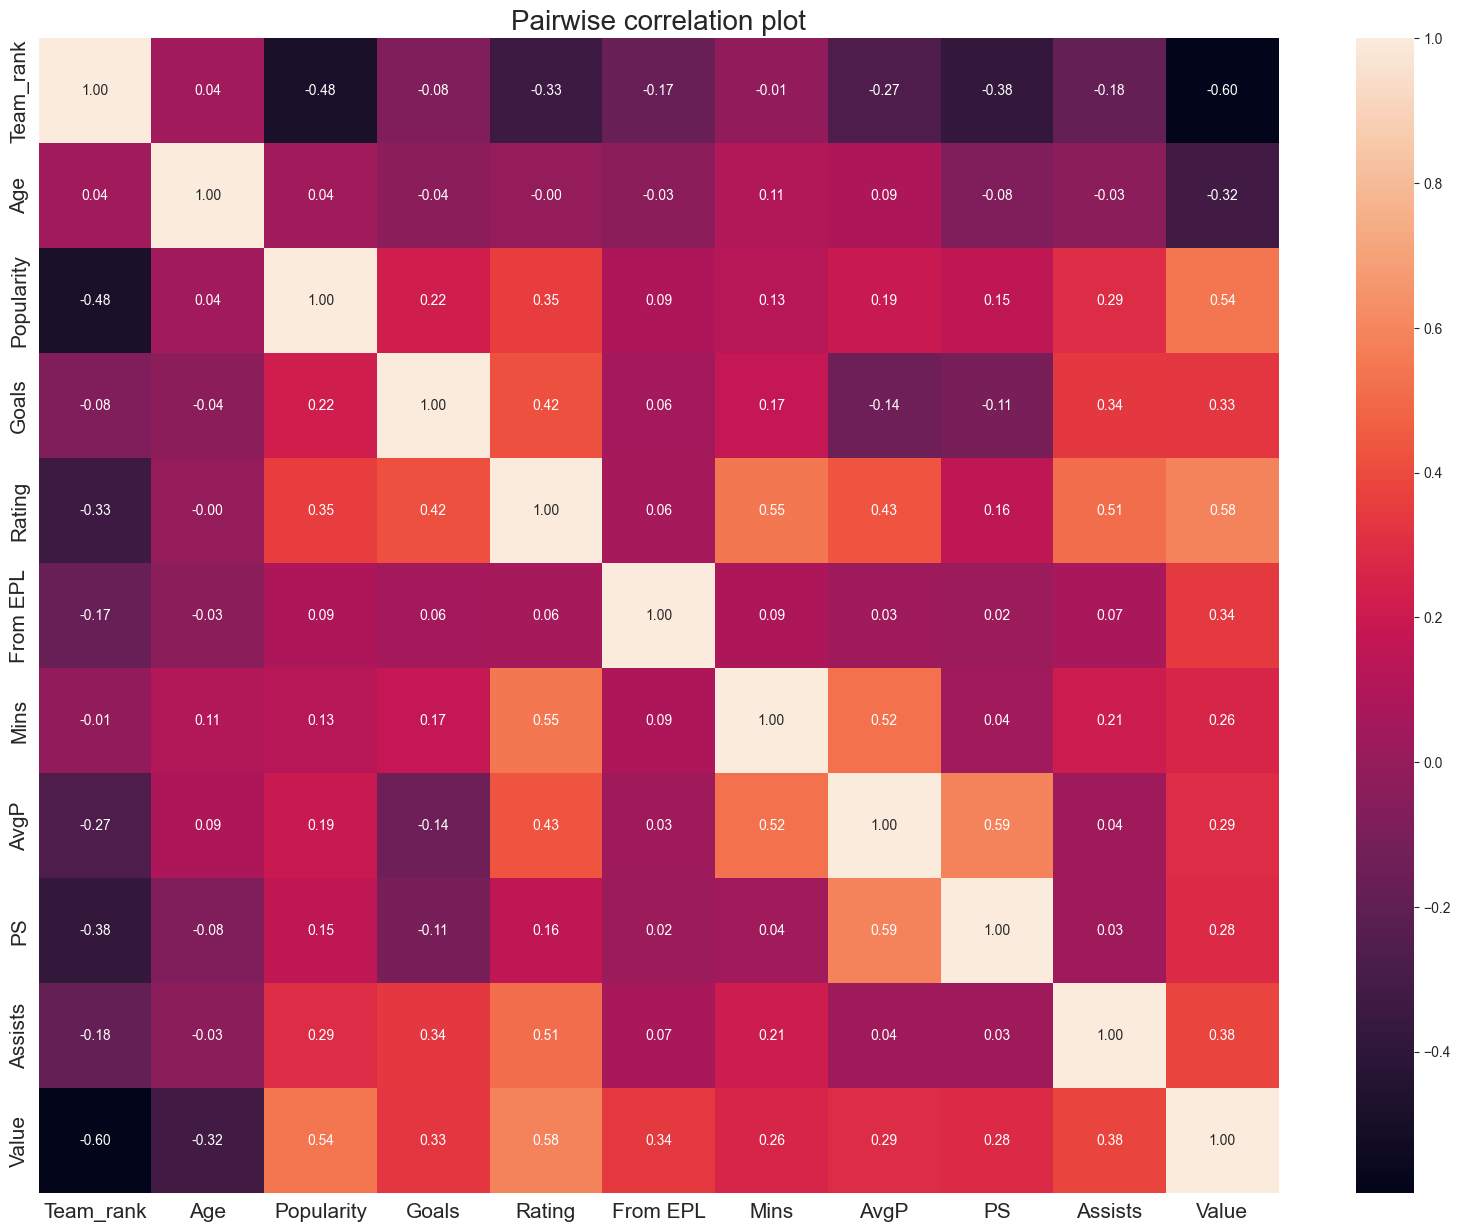

In [137]:
corr_table = df_train.corr(numeric_only=True)

fig, ax = plt.subplots(figsize=(20, 15))

sns.heatmap(corr_table,
            annot=True,
            fmt='.2f',
            ax=ax)

ax.set_title('Pairwise correlation plot', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)

plt.show()

**3. LEARNING A MODEL**

This section will be divided into 3 parts. In the first part we will create the DecisionTree model to see how it makes decisions on the data and how well it performs. In the next part we will examine all the basic machine learning models in order to choose the best one. In the final part we will choose one of the algorithms and learn it via GridSearch with a larger hyperparameters grid 

In [ ]:
# We use embedded method (ExtraTrees -> feature_importances_) and drop some other variables:
#all_data.drop(['Start_Apps', 'LongB', 'Yel', 'Drb_y', 'Tackles',
#               'Position_1_Sides', 'Clear', 'Assists', 'Position_3',
#               'Position_1', 'Main side_1', 'Position_2', 'Main side_2'], axis=1, inplace=True)

In [138]:
df_train, df_test = divide_df(all_data)

X_train, y_train = df_train.drop('Value', axis=1), df_train['Value']
X_test, y_test = df_test.drop('Value', axis=1), df_test['Value']

feature_names = X_train.columns

n_folds = 5

#X_train = StandardScaler().fit_transform(X_train)
#X_test = StandardScaler().fit_transform(X_test)

In [831]:
X_train

,Team_rank,Age,Popularity,Goals,Rating,From EPL,Mins,AvgP,PS,LongB
0,1,30,1.0,0,6.50,False,585,14.4,70.6,0.4
1,2,28,1.0,0,6.40,False,996,26.5,62.0,6.4
2,2,20,1.0,0,6.00,True,77,4.3,53.3,0.0
3,1,23,1.0,0,6.70,False,403,31.0,85.4,1.0
4,0,28,3.0,0,6.89,False,466,54.6,91.6,2.4
...,...,...,...,...,...,...,...,...,...,...
1231,2,28,1.0,0,6.75,True,937,28.7,78.8,1.4
1232,2,25,1.0,0,6.55,True,597,11.9,72.4,0.4
1233,2,22,1.0,0,6.46,False,488,21.7,77.3,0.9
1234,1,32,1.0,0,6.92,False,1123,31.8,75.9,5.2


*1. Decision Tree*

In this part we will create a basic decision tree and then visualize it. This model is good at representativeness and interpretability so we must know how to deal with it

In [832]:
# Train a basic model - without any hyperparameter fine-tuning
basic_decision_tree = DecisionTreeRegressor()

In [833]:
basic_decision_tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [144]:
def regression_metrics(prediction, reality):
    maximum = max(reality)
    minimum = min(reality)
    
    print(f'RMSE: {root_mean_squared_error(prediction, reality)}')
    print(f'Normalized RMSE: {root_mean_squared_error(prediction, reality)/(maximum-minimum)}')
    print(f'log RMSE: {root_mean_squared_log_error(np.abs(prediction), reality)}')
    print(f'MAPE: {mean_absolute_percentage_error(prediction, reality)}')
    print(f'R2 score: {r2_score(prediction, reality)}')
    
def show_predictions(model):
    answers = pd.DataFrame([test_names.values, y_test.values, pd.Series(model.predict(X_test))]).T
    answers.rename(columns={0: 'Name', 1: 'Test value', 2: 'Predicted value'}, inplace=True)
    
    return answers

def show_importances(features, model):
    feature_importances = pd.DataFrame(model.feature_importances_, index=features, columns=['Importance'])
    feature_importances.sort_values(by='Importance', ascending=False, inplace=True)
    
    return feature_importances

def rmse_cv(model):
    kfolds = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y_train, cv=kfolds, scoring='neg_mean_squared_error'))
    
    return rmse

In [834]:
regression_metrics(basic_decision_tree.predict(X_train), y_train)

RMSE: 0.0
Normalized RMSE: 0.0
log RMSE: 0.0
MAPE: 0.0
R2 score: 1.0


In [835]:
regression_metrics(basic_decision_tree.predict(X_test), y_test)

RMSE: 10692343.227922667
Normalized RMSE: 0.14304138097555408
log RMSE: 0.6907318655614163
MAPE: 0.5911962591225812
R2 score: 0.5885161768180285


In [ ]:
display(show_predictions(basic_decision_tree).sample(5))

We see that this model expectedly overfits the data. Let`s somehow adjust our algorithm

In [ ]:
vis_decision_tree = DecisionTreeRegressor(max_depth=3)

In [ ]:
vis_decision_tree.fit(X_train, y_train)

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

plot_tree(vis_decision_tree, feature_names=feature_names, filled=True, fontsize=8)

plt.show()

In [ ]:
display(show_importances(feature_names, vis_decision_tree).head(8))

The basic decision tree with max_depth = 3 makes its decisions based mainly on the rating, rank of the team in which a footballer plays and his age. So our new feature 'Team_rank' is very important for this ML algorithm. Let`s check the same thing for the first tree

In [ ]:
display(show_importances(feature_names, basic_decision_tree))

In [ ]:
regression_metrics(vis_decision_tree.predict(X_train), y_train)

In [ ]:
regression_metrics(vis_decision_tree.predict(X_test), y_test)

This model has problem with underfitting the data. So let`s use the RandomizedSearch algorithm in order to get the best possible tree. It will be faster than usual GridSearch and may give better performance.

In [ ]:
decision_tree_param_grid = {
    'max_depth': [1, 3, 5, 7, 11, 13, 15],
    'min_samples_split': sp_randint(2, 16),
    'min_samples_leaf': sp_randint(2, 16)
}

In [ ]:
tune_decision_tree = RandomizedSearchCV(DecisionTreeRegressor(), decision_tree_param_grid, n_iter=300, cv=5, random_state=42)
tune_decision_tree.fit(X_train, y_train)

In [ ]:
best_decision_tree = tune_decision_tree.best_estimator_

In [ ]:
best_decision_tree.fit(X_train, y_train)

In [ ]:
show_importances(feature_names, best_decision_tree)

In [ ]:
regression_metrics(best_decision_tree.predict(X_train), y_train)

In [810]:
regression_metrics(best_decision_tree.predict(X_test), y_test)

NameError: name 'best_decision_tree' is not defined

In [811]:
display(show_predictions(best_decision_tree).sample(10))

NameError: name 'best_decision_tree' is not defined

This model performs better. But we see that it shows poor performance and doesn't use all the features we have. Let's check other ML algorithms and choose the best one

*2. Choosing a model*

In [836]:
all_models = [
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    BaggingRegressor(),
    AdaBoostRegressor(),
    GradientBoostingRegressor(),
    XGBRegressor(),
    ExtraTreesRegressor(),
    
    SVR(),
    NuSVR(),
    
    LinearRegression(),
    SGDRegressor(),
    Ridge(), 
    Lasso(), 
    ElasticNet(), 
    BayesianRidge()
]

In [837]:
cv_splits = KFold(n_splits=5, shuffle=True)

scores_table = pd.DataFrame(columns=['train RMSE', 'test RMSE', 'train RMSE 3std', 'test RMSE 3std'])
predictions_table = pd.DataFrame(y_train, index=y_train.index)

for alg in all_models:
    alg_name = alg.__class__.__name__
    
    cv_results = cross_validate(alg, 
                                X_train, 
                                y_train,
                                cv=cv_splits,
                                scoring='neg_root_mean_squared_error',
                                return_train_score=True)
    
    scores_table.loc[alg_name, 'train RMSE'] = -cv_results['train_score'].mean()
    scores_table.loc[alg_name, 'test RMSE'] = -cv_results['test_score'].mean()
    #scores_table.loc[alg_name, 'train R2'] = cv_results['train_score'].mean()
    #scores_table.loc[alg_name, 'test R2'] = cv_results['test_score'].mean()
    
    scores_table.loc[alg_name, 'train RMSE 3std'] = cv_results['train_score'].std()*3
    scores_table.loc[alg_name, 'test RMSE 3std'] = cv_results['test_score'].std()*3
    #scores_table.loc[alg_name, 'train R2 3std'] = cv_results['train_score'].std()*3
    #scores_table.loc[alg_name, 'test R2 3std'] = cv_results['test_score'].std()*3
    
    alg.fit(X_train, y_train)
    
    predictions_table.loc[:, alg_name] = alg.predict(X_train)
    
scores_table.sort_values(by='test RMSE', ascending=True, inplace=True)

In [838]:
display(scores_table)

,train RMSE,test RMSE,train RMSE 3std,test RMSE 3std
RandomForestRegressor,3008980.036381,7686743.02274,391350.992008,2631957.010196
ExtraTreesRegressor,9594.250684,7689581.072169,26657.504475,1154995.717652
GradientBoostingRegressor,5125052.380857,7771382.66641,438572.080453,2825844.518195
XGBRegressor,412306.127591,8312203.606933,76064.413567,1435301.0365
BaggingRegressor,3579371.46004,8480062.738852,580175.273972,1918370.162151
LinearRegression,8560977.823833,8682097.62725,457876.069723,1802403.300587
Lasso,8556232.752366,8703089.76372,582950.908681,2270146.411969
BayesianRidge,8559594.683097,8709336.199384,408150.146333,1672446.492068
Ridge,8559739.952917,8724458.573427,236055.693263,857900.346677
AdaBoostRegressor,9297449.429151,10389740.545649,1324474.910774,1367524.572942


We see that the best performance show ensemble and boosting methods like Gradient Boosting or Random Forest, but we also can notice that SVM algorithm obviously has an underfitting problem, so we can try to somehow fine-tune it (using kernels or adjusting the values of hyperparameters). But now we will try to use the RandomForestRegressor and find the best values of hyperparameters via GridSearchCV.

In [839]:
# GRID PARAMETERS

# 1. Lasso regression
lasso_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 125, 150, 175,
              200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1700, 2000, 2500, 3000,
              3500, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 12000, 14000, 16000, 18000, 20000,
              25000, 30000, 35000, 40000, 50000, 60000, 70000, 80000, 81500, 81510, 81520, 81530],
    'positive': [True, False]
}

# 2. Ridge regression
ridge_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 17, 18, 18.2, 18.25, 18.26, 18.27, 18.28, 18.29, 18.3,
              18.31, 18.32, 18.33, 18.34, 18.35, 18.4, 18.5, 18.6, 19, 20, 22, 24, 25, 30, 40, 50, 60,
              70, 80, 90, 100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1200,
              1500, 1700, 2000, 2500, 3000, 3500, 4000, 5000, 6000, 7000, 8000, 9000, 10000],
    'positive': [True, False]
}

# 3. ElasticNet
elastic_grid_params = {
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10],
    'l1_ratio': np.arange(0.6, 0.9, 0.01)
}

# 4. KernelRidge regression
kernelridge_grid_params = {
    'kernel': ['linear', 'polynomial', 'rbf', 'sigmoid'],
    'gamma': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'coef0': [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5, 7, 10]
}

# 5. GradientBoosting (n_iters = 3000)
gradient_grid_params = {
    'loss': ['squared_error', 'huber'],
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 1, 0.05),
    'max_depth': np.arange(1, 19, 2),
    'max_features': [None, 'sqrt'],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 19)
}

# 6. XGBoost
xgboost_grid_params = {
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 0.5, 0.025),
    'max_depth': np.arange(1, 19, 2),
    'gamma': [0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 3, 5, 7, 10],
    'min_child_weight': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500],
    'subsample': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.63, 0.66, 0.69, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'colsample_bytree':np.arange(0, 1, 0.05),
    'lambda': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'eval_metric': ['rmse']
}

# 7. LightGBM
lightgbm_grid_params = {
    'objective': ['regression', 'regression_l1', 'huber'],
    'n_estimators': [10, 30, 50, 70, 100, 300, 500, 1000],
    'learning_rate': np.arange(0, 0.5, 0.025),
    'max_depth': np.arange(1, 19, 2),
    'gamma': [0.05, 0.07, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 1, 3, 5, 7, 10],
    'min_samples_leaf': np.arange(1, 19),
    'min_child_weight': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500],
    'subsample': [0.5, 0.52, 0.54, 0.56, 0.58, 0.6, 0.63, 0.66, 0.69, 0.75, 0.8, 0.85, 0.9, 0.95, 1],
    'subsample_freq': [0, 2, 3, 4, 5],
    'colsample_bytree':np.arange(0, 1, 0.05),
    'reg_lambda': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'reg_alpha': [0.001, 0.01, 0.1, 1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90,
              100, 125, 150, 175, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000],
    'max_bin': [0.5, 1, 1.05, 1.15, 1.35, 1.5, 1.7, 2, 2.5, 3, 5, 7, 10, 15, 30, 50, 100, 200, 300, 500]
}

In [ ]:
random_forest_grid = {
    'max_depth': range(5, 14, 2),
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(1, 11, 2),
    'max_features': np.arange(0.6, 1.1, 1),
    'n_estimators': [100]
}

In [ ]:
tune_random_forest = GridSearchCV(RandomForestRegressor(), random_forest_grid)
tune_random_forest.fit(X_train, y_train)

In [ ]:
best_random_forest = RandomForestRegressor(n_estimators=1000,
                                           max_depth=13,
                                           max_features=0.6,
                                           min_samples_leaf=1,
                                           min_samples_split=2)

In [ ]:
best_random_forest.fit(X_train, y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_train), y_train)

In [ ]:
regression_metrics(best_random_forest.predict(X_test), y_test)

In [ ]:
show_predictions(best_random_forest)

In [ ]:
basic_random_forest = RandomForestRegressor()
basic_random_forest.fit(X_train, y_train)

In [ ]:
extra_grid_params = {
    'max_depth': [5, 7, 9, 11, 13, 15, 17, 19, 21],
    'min_samples_leaf': [2, 4, 6, 8, 10, 12, 14]
}

In [ ]:
tune_extra_trees = GridSearchCV(ExtraTreesRegressor(), extra_grid_params, scoring='r2', cv=5)
tune_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = tune_extra_trees.best_estimator_
best_extra_trees.fit(X_train, y_train)

In [ ]:
best_extra_trees = ExtraTreesRegressor(max_depth=9, min_samples_leaf=3, n_estimators=1000)
best_extra_trees.fit(X_train, y_train)

In [ ]:
regression_metrics(best_extra_trees.predict(X_train), y_train)
print('=' * 25)
regression_metrics(best_extra_trees.predict(X_test), y_test)

In [ ]:
show_importances(feature_names, best_extra_trees)

In [ ]:
a = show_predictions(best_extra_trees)
display(a.sample(20))

In [ ]:
tune_xgboost_regressor = RandomizedSearchCV(XGBRegressor(), xgboost_grid_params, n_iter=30, scoring='neg_mean_squared_error', cv=5)
tune_xgboost_regressor.fit(X_train, y_train)

In [ ]:
best_xgboost_regressor = tune_xgboost_regressor.best_estimator_
best_xgboost_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_train), y_train)

In [ ]:
regression_metrics(best_xgboost_regressor.predict(X_test), y_test)

In [ ]:
pred = show_predictions(best_xgboost_regressor)

In [ ]:
pred[abs(pred['Test value'] - pred['Predicted value']) > 15000000]

In [ ]:
fine_ridge_regressor = GridSearchCV(Ridge(), ridge_grid_params, scoring='neg_mean_squared_error', cv=5)
fine_ridge_regressor.fit(X_train, y_train)

In [ ]:
best_ridge_regressor = fine_ridge_regressor.best_estimator_
best_ridge_regressor.fit(X_train, y_train)

In [ ]:
regression_metrics(best_ridge_regressor.predict(X_train), y_train)
print('=' * 25)
regression_metrics(best_ridge_regressor.predict(X_test), y_test)

In [ ]:
pred2 = show_predictions(best_ridge_regressor)

In [ ]:
pred2[abs(pred2['Test value'] - pred2['Predicted value']) > 15000000]

In [139]:
# Lasso. Best params: alpha=81500, positive=False
lasso = make_pipeline(RobustScaler(), Lasso(alpha=81500,
                                            positive=False))

# Ridge. Best params: alpha=18.3, positive=False
ridge = make_pipeline(RobustScaler(), Ridge(alpha=18.3,
                                            positive=False))

# ElasticNet. Best params: alpha=0.1, l1_ratio=0.8100000000000002
elastic = make_pipeline(RobustScaler(), ElasticNet(alpha=0.1,
                                                   l1_ratio=0.8100000000000002,
                                                   positive=False))

# KernelRidge. Best params: kernel='polynomial', gamma=0.001, degree=3, coef0=31
kernelridge = KernelRidge(kernel='polynomial',
                          gamma=0.001,
                          degree=3,
                          coef0=31)

# GradientBoosting. Best params: loss='squared_error', n_estimators=600, learning_rate=0.05, min_samples_split=3, min_samples_leaf=3
gradient = GradientBoostingRegressor(loss='squared_error',
                                     n_estimators=600,
                                     learning_rate=0.05,
                                     min_samples_split=3,
                                     min_samples_leaf=3,
                                     max_depth=3,
                                     max_features=None)

# XGBoost. Best params: alpha=0, colsample_bytree=0.8, eval_metric='rmse', gamma=0.4, learning_rate=0.10000000000000002,
# max_depth=3,min_child_weight=2, n_estimators=250, subsample=0.9
xgboost = XGBRegressor(alpha=0,
                       colsample_bytree=0.8,
                       eval_metric='rmse',
                       gamma=0.4,
                       learning_rate=0.10000000000000002,
                       max_depth=3,
                       min_child_weight=2,
                       n_estimators=250,
                       subsample=0.9)

# LightGBM. Best params: colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_bin=1023, max_depth=9, min_child_weight=2,
# min_samples_leaf=3, n_estimators=500, objective='regression', reg_alpha=0.001, subsample=0.8, subsample_freq=2
lightgbm = LGBMRegressor(colsample_bytree=0.8,
                         gamma=0.4,
                         learning_rate=0.05,
                         max_bin=1023,
                         max_depth=9,
                         min_child_weight=2,
                         min_samples_leaf=3,
                         n_estimators=500,
                         objective='regression',
                         reg_alpha=0.001,
                         subsample=0.8,
                         subsample_freq=2)

# RandomForest
random_forest = RandomForestRegressor(n_estimators=1000,
                                      max_depth=13,
                                      max_features=0.6,
                                      min_samples_leaf=1,
                                      min_samples_split=2)

In [140]:
lasso.fit(X_train, y_train)
ridge.fit(X_train, y_train)
elastic.fit(X_train, y_train)
kernelridge.fit(X_train, y_train)
gradient.fit(X_train, y_train)
xgboost.fit(X_train, y_train)
lightgbm.fit(X_train, y_train)
#random_forest.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 10
[LightGBM] [Info] Start training from score 14343563.122924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMRegressor(colsample_bytree=0.8, gamma=0.4, learning_rate=0.05, max_bin=1023,
              max_depth=9, min_child_weight=2, min_samples_leaf=3,
              n_estimators=500, objective='regression', reg_alpha=0.001,
              subsample=0.8, subsample_freq=2)

In [843]:
regression_metrics(lasso.predict(X_train), y_train)
print('=' * 25)
regression_metrics(lasso.predict(X_test), y_test)

RMSE: 8585575.527279591
Normalized RMSE: 0.095448310475593
log RMSE: 0.8955593710069139
MAPE: 1.0176884956541625
R2 score: 0.6061666659356206
RMSE: 8263662.964879208
Normalized RMSE: 0.11055067511544091
log RMSE: 0.8861035214946189
MAPE: 0.803746786750495
R2 score: 0.6069876153781366


In [844]:
regression_metrics(ridge.predict(X_train), y_train)
print('=' * 25)
regression_metrics(ridge.predict(X_test), y_test)

RMSE: 8586423.254345657
Normalized RMSE: 0.09545773490100787
log RMSE: 0.880834294022747
MAPE: 0.9326222771260361
R2 score: 0.602893264475552
RMSE: 8266860.382030492
Normalized RMSE: 0.11059344992682932
log RMSE: 0.9386032026136157
MAPE: 1.3294561800471538
R2 score: 0.6033557319564238


In [845]:
regression_metrics(elastic.predict(X_train), y_train)
print('=' * 25)
regression_metrics(elastic.predict(X_test), y_test)

RMSE: 8591606.951657252
Normalized RMSE: 0.09551536355372153
log RMSE: 0.8742842547892031
MAPE: 0.8504398290583244
R2 score: 0.5980495872415472
RMSE: 8267380.604078876
Normalized RMSE: 0.11060040941911539
log RMSE: 0.909187291603496
MAPE: 0.9756074081128434
R2 score: 0.5987486797666706


In [846]:
regression_metrics(kernelridge.predict(X_train), y_train)
print('=' * 25)
regression_metrics(kernelridge.predict(X_test), y_test)

RMSE: 7077834.200864998
Normalized RMSE: 0.07868631685230681
log RMSE: 0.7744676425436239
MAPE: 1.3352898381127103
R2 score: 0.7660540604257594
RMSE: 7228202.839545942
Normalized RMSE: 0.096698365746434
log RMSE: 0.7722619932844957
MAPE: 0.9923844765474361
R2 score: 0.7274809907937674


In [847]:
regression_metrics(gradient.predict(X_train), y_train)
print('=' * 25)
regression_metrics(gradient.predict(X_test), y_test)

RMSE: 3881894.9205087675
Normalized RMSE: 0.04315614141755161
log RMSE: 0.5402268153595103
MAPE: 0.4823507355927141
R2 score: 0.9360916422097948
RMSE: 7160516.772584391
Normalized RMSE: 0.0957928665228681
log RMSE: 0.8462282274432196
MAPE: 2.4807566200749567
R2 score: 0.7445303424114897


In [848]:
regression_metrics(xgboost.predict(X_train), y_train)
print('=' * 25)
regression_metrics(xgboost.predict(X_test), y_test)

RMSE: 4182525.7682476356
Normalized RMSE: 0.04649834094772246
log RMSE: 0.5571023086706504
MAPE: 0.5453265585923429
R2 score: 0.9249290823936462
RMSE: 7055126.6129907295
Normalized RMSE: 0.09438296472228401
log RMSE: 0.7383837370114821
MAPE: 0.9055731017677529
R2 score: 0.753662645816803


In [849]:
regression_metrics(lightgbm.predict(X_train), y_train)
print('=' * 25)
regression_metrics(lightgbm.predict(X_test), y_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 639482.3987277871
Normalized RMSE: 0.0071093096023100285
log RMSE: 0.2008830103084317
MAPE: 0.10787673466223861
R2 score: 0.9984449421570959
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 6977231.6576929195
Normalized RMSE: 0.0933408917417113
log RMSE: 0.5908895148167536
MAPE: 0.5264628016332814
R2 score: 0.7581483168985638


In [850]:
regression_metrics(random_forest.predict(X_train), y_train)
print('=' * 25)
regression_metrics(random_forest.predict(X_test), y_test)

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
df1 = show_importances(feature_names, xgboost)
df1 = df1.rename(columns={'Importance': 'XGBoost'})

df2 = show_importances(feature_names, gradient)
df2 = df2.rename(columns={'Importance': 'GradietntBoosting'})

df3 = show_importances(feature_names, lightgbm)
df3 = df3.rename(columns={'Importance': 'LightGBM'})

In [ ]:
pd.concat([df1, df2, df3], axis=1)



In [141]:
class AveragingModel(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(model) for model in self.models]
        
        for model in self.models_:
            model.fit(X, y)
        
        return self
    
    def predict(self, X):
        predictions = np.column_stack([model.predict(X) for model in self.models_])
        return np.mean(predictions, axis=1)

In [142]:
av_model = AveragingModel([kernelridge, gradient, xgboost, lightgbm])
av_model.fit(X_train, y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1043
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 10
[LightGBM] [Info] Start training from score 14343563.122924
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


AveragingModel(models=[KernelRidge(coef0=31, gamma=0.001, kernel='polynomial'),
                       GradientBoostingRegressor(learning_rate=0.05,
                                                 min_samples_leaf=3,
                                                 min_samples_split=3,
                                                 n_estimators=600),
                       XGBRegressor(alpha=0, base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.8,
                                    device=None, early_stopping_rounds=None,
                                    e...
                                    min_child_weight=2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=250,
                                    n_jobs=None, num_parallel_tree=None, ...),
                       LGBMRegressor(colsample_bytree=0.8, gamma=0.4,
                                     learning_rate=0.05, max_bin=1023,
                                     max_depth=9, min_child_weight=2,
                                     min_samples_leaf=3, n_estimators=500,
                                     objective='regression', reg_alpha=0.001,
                                     subsample=0.8, subsample_freq=2)])

In [145]:
regression_metrics(av_model.predict(X_train), y_train)
print('=' * 25)
regression_metrics(av_model.predict(X_test), y_test)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 3736211.3061936176
Normalized RMSE: 0.0415365348103793
log RMSE: 0.4722946028632216
MAPE: 0.38423777946404447
R2 score: 0.9395166831794177
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3
RMSE: 6700518.460932232
Normalized RMSE: 0.08963904295561514
log RMSE: 0.6178577149006689
MAPE: 0.5701097661081646
R2 score: 0.7686454386932657


In [854]:
pred = show_predictions(av_model)
pred[abs(pred['Test value'] - pred['Predicted value']) > 5000000]

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=3. Current value: min_data_in_leaf=3


,Name,Test value,Predicted value
0,Paulo Dybala,20000000,26861948.705831
2,Aimar Oroz,15000000,7202311.011748
3,Maximilian Mittelstädt,17000000,29208533.236002
8,João Félix,30000000,48025474.029627
9,Igor Zubeldia,22000000,16347099.403661
...,...,...,...
281,Harry Maguire,18000000,28201155.416477
285,Robin Hack,8000000,24711030.754023
288,Nathan Tella,23000000,14957515.578945
291,Dominic Calvert-Lewin,22000000,31737921.06785


In [855]:
class StackingAverageModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
    
    def fit(self, X, y):
        self.base_models_ = [list() for model in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models_)))
        
        for index, model in enumerate(self.base_models):
            for train_indices, holdout_indices in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[index].append(instance)
                instance.fit(X.iloc[train_indices, :], y[train_indices])
                predictions = instance.predict(X.iloc[holdout_indices, :])
                out_of_fold_predictions[holdout_indices, index] = predictions
        
        self.meta_model_.fit(out_of_fold_predictions, y)
        
        print(out_of_fold_predictions)
        
        return self
    
    def predict(self, X):
        meta_features = np.column_stack(
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1) for base_models in self.base_models_
        )
        
        return self.meta_model_.predict(meta_features)

In [856]:
stacking_model = StackingAverageModels([lasso, lightgbm, kernelridge, gradient, xgboost], lightgbm)
stacking_model.fit(X_train, y_train)

KeyError: '[26, 33, 48, 66, 77, 104, 134, 144, 190, 217, 305, 343, 441, 474, 641, 724, 802, 867, 896, 902, 918, 1001, 1019, 1040, 1069, 1199, 1202] not in index'

In [ ]:
regression_metrics(stacking_model.predict(X_train), y_train)
print('=' * 25)
regression_metrics(stacking_model.predict(X_test), y_test)

In [146]:
with open('final_model.pkl', 'wb') as file:
    dill.dump(av_model, file)

In [150]:
dataframe = pd.DataFrame(columns=feature_names)

In [151]:
dataframe.to_csv(r'./page/online_data.csv', index=False)